In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
import ott # jax-ott
import seaborn as sns

In [19]:
# Define the two-stream distribution with spatial dependence
def two_stream_distribution(x, v, v_bar, epsilon, beta):
    return (1 / (2 * jnp.sqrt(2 * jnp.pi))) * (
        jnp.exp(-(v - v_bar)**2 / 2) + jnp.exp(-(v + v_bar)**2 / 2)
    ) * (1 + epsilon * jnp.cos(beta * x))

# Generate particles with weight normalization for each x
def generate_particles_equilibrium_two_stream(f, N, L, v_max):
    """
    Generates N^2 particles uniformly distributed on the domain.
    Evaluates the function f(x, v) at the center of each small square.

    Parameters:
    f (function): Function of x and v, f(x,v)
    N (int): Number of grid points along each dimension (total N^2 particles)
    L (float): Length of the domain for x (domain [0, L])
    v_max (float): Maximum value for v (domain [-v_max, v_max])
    epsilon (float): Perturbation parameter for normalization
    beta (float): Spatial frequency for normalization

    Returns:
    particles (list): A list of particles, where each particle is represented as a tuple (x, v, weight)
    """

    # Define the step sizes for x and v
    dx = L / N
    dv = 2 * v_max / N

    # Create the particle list
    #particles = []
    particles = jnp.zeros((N**2,3))

    # Loop over each point in the x grid
    for i in range(N):
        x = (i + 0.5) * dx  # Center of the current x cell
        normalization_factor = dx  # Target sum for weights over v

        # Store the weights for this x over all velocities
        # weights = []
        weights = jnp.zeros(N)
        for j in range(N):
            v = -v_max + (j + 0.5) * dv  # Center of the current v cell
            weight = f(x, v) * dx * dv
            weights = weights.at[j].set(weight)
            #weights.append(weight)

        # Normalize weights for the current x to match the desired sum
        weight_sum = jnp.sum(weights)
        if weight_sum != 0:  # Avoid division by zero
            normalized_weights = [w * normalization_factor / weight_sum for w in weights]
        else:
            normalized_weights = weights  # If the sum is zero, no need to normalize

        # Append the particles with the normalized weights
        for j, v in enumerate(np.linspace(-v_max + 0.5 * dv, v_max - 0.5 * dv, N)):
            particle = jnp.array([x,v,normalized_weights[j]])
            particles = particles.at[i*N+j,:].set(particle)
            #particles.append((x, v, normalized_weights[j]))

    return particles


# Generate particles with weight normalization for each x
def generate_particles_two_stream(f, N, L, v_max, epsilon, beta):
    """
    Generates N^2 particles uniformly distributed on the domain.
    Evaluates the function f(x, v) at the center of each small square.

    Parameters:
    f (function): Function of x and v, f(x,v)
    N (int): Number of grid points along each dimension (total N^2 particles)
    L (float): Length of the domain for x (domain [0, L])
    v_max (float): Maximum value for v (domain [-v_max, v_max])
    epsilon (float): Perturbation parameter for normalization
    beta (float): Spatial frequency for normalization

    Returns:
    particles (list): A list of particles, where each particle is represented as a tuple (x, v, weight)
    """

    # Define the step sizes for x and v
    dx = L / N
    dv = 2 * v_max / N

    # Create the particle list
    #particles = []
    particles = jnp.zeros((N**2,3))

    # Loop over each point in the x grid
    for i in range(N):
        x = (i + 0.5) * dx  # Center of the current x cell
        normalization_factor = (1 + epsilon * jnp.cos(beta * x)) * dx  # Target sum for weights over v

        # Store the weights for this x over all velocities
        #weights = []
        weights = jnp.zeros(N)
        for j in range(N):
            v = -v_max + (j + 0.5) * dv  # Center of the current v cell
            weight = f(x, v) * dx * dv
            #weights.append(weight)
            weights = weights.at[j].set(weight)

        # Normalize weights for the current x to match the desired sum
        weight_sum = jnp.sum(weights)
        if weight_sum != 0:  # Avoid division by zero
            normalized_weights = [w * normalization_factor / weight_sum for w in weights]
        else:
            normalized_weights = weights  # If the sum is zero, no need to normalize

        # Append the particles with the normalized weights
        for j, v in enumerate(np.linspace(-v_max + 0.5 * dv, v_max - 0.5 * dv, N)):
            #particles.append((x, v, normalized_weights[j]))
            particle = jnp.array([x,v,normalized_weights[j]])
            particles = particles.at[i*N+j,:].set(particle)

    return particles


# Compute the density rho(x) from particles
def compute_density(particles, N, L):
    """
    Compute the density rho(x) based on the positions of particles.

    Parameters:
    particles (list): List of particles, where each particle is represented as a tuple (x, v, weight)
    N (int): Number of cells along the x dimension
    L (float): Length of the domain for x (domain [0, L])

    Returns:
    rho_x (numpy array): Density values rho(x) at the center of each cell in the spatial domain
    x_centers (numpy array): Positions of the cell centers
    """

    # Define the step size for x
    dx = L / N

    # Initialize rho(x) for each cell
    rho_x = jnp.zeros(N)

    # Loop over the particles and accumulate their weights in the corresponding cell
    for x, _, weight in particles:
        # Find the index of the cell where this particle falls
        cell_index = int(x // dx)  # Find which cell the particle belongs to
        rho_x = rho_x.at[cell_index].add(weight)  # Add the particle's weight to the cell

    # Compute the x positions of the cell centers
    x_centers = (jnp.arange(N) + 0.5) * dx

    return x_centers, rho_x / dx


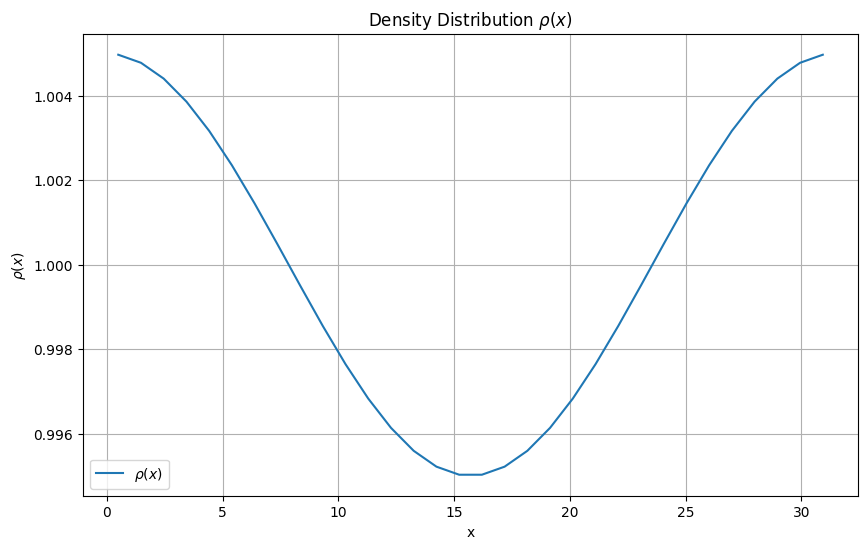

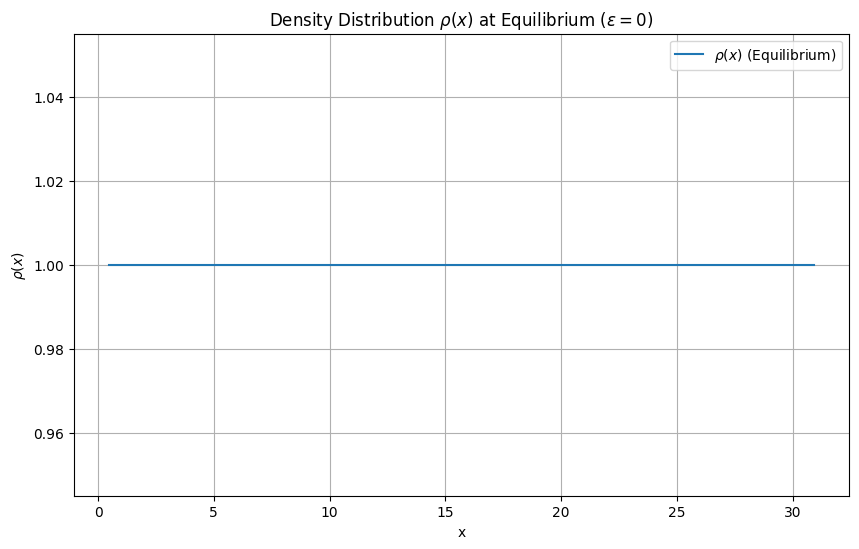

In [20]:
# Example usage
# Parameters
N = 32
L = 10.0 * jnp.pi
v_max = 8.0
v_bar = 2.4
epsilon = 0.005
beta = 0.2

# Generate particles using the two-stream distribution
particles = generate_particles_two_stream(lambda x, v: two_stream_distribution(x, v, v_bar, epsilon, beta), N, L, v_max, epsilon, beta)

# Set the parameters for the equilibrium two-stream distribution (epsilon = 0)
epsilon_eq = 0.0

# Generate particles for the equilibrium distribution
equilibrium_particles = generate_particles_equilibrium_two_stream(
    lambda x, v: two_stream_distribution(x, v, v_bar, epsilon_eq, beta),
    N, L, v_max
)

# Compute the density rho(x)
x_centers, rho_x = compute_density(particles, N, L)

# Plot the density rho(x)
plt.figure(figsize=(10, 6))
plt.plot(x_centers, rho_x, label=r'$\rho(x)$')
plt.title(r'Density Distribution $\rho(x)$')  # Fixed title with correct LaTeX syntax
plt.xlabel('x')
plt.ylabel(r'$\rho(x)$')
plt.grid(True)
plt.legend()
plt.show()

# Compute the density rho(x) for the equilibrium state
x_centers_eq, rho_x_eq = compute_density(equilibrium_particles, N, L)

# Plot the density rho(x) for the equilibrium state
plt.figure(figsize=(10, 6))
plt.plot(x_centers_eq, rho_x_eq, label=r'$\rho(x)$ (Equilibrium)')
plt.title(r'Density Distribution $\rho(x)$ at Equilibrium ($\epsilon=0$)')
plt.xlabel('x')
plt.ylabel(r'$\rho(x)$')
plt.grid(True)
plt.legend()
plt.show()

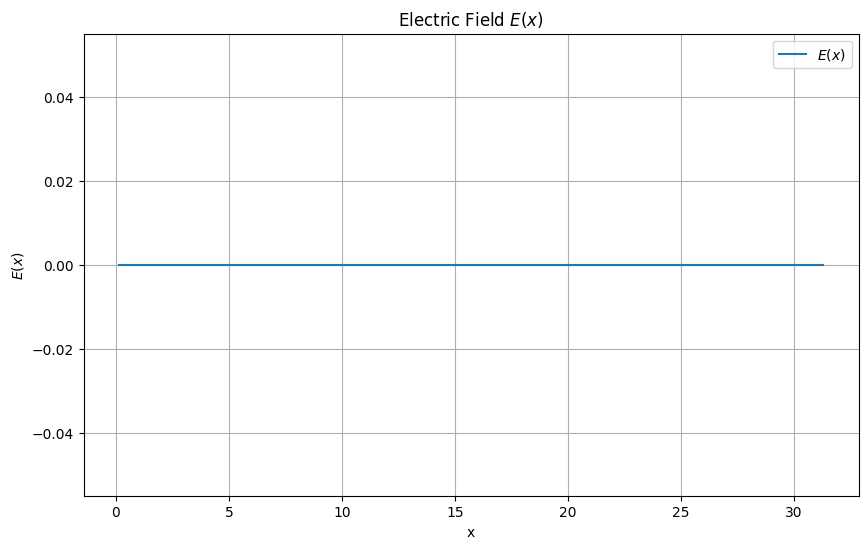

In [21]:
# Fourier solver to compute the electric field E(x)
def compute_electric_field(rho_x, N, L):
    """
    Compute the electric field E(x) from the charge density rho(x) using Fourier transforms.

    Parameters:
    rho_x (numpy array): The density values rho(x)
    N (int): Number of grid points
    L (float): Length of the domain for x (domain [0, L])

    Returns:
    E_x (numpy array): Electric field values E(x)
    """

    # Subtract background density 1 from rho to get charge density fluctuation
    delta_rho = rho_x - 1

    # Compute the Fourier transform of delta_rho
    #delta_rho_k = fft(delta_rho)
    delta_rho_k = jnp.fft.fft(delta_rho)

    # Create the wave numbers for Fourier space
    k = jnp.fft.fftfreq(N, d=L/N) * 2 * np.pi  # Frequencies in Fourier space

    # Avoid division by zero for k = 0
    k = k.at[0].set(1e-12)

    # Solve for V(k) in Fourier space: V_k = delta_rho_k / (k^2)
    V_k = -delta_rho_k / (k**2)
    V_k= V_k.at[0].set(0)  # Set the zero mode (constant) to 0 to avoid potential shift

    # Compute the electric field in Fourier space: E_k = -ik * V_k
    E_k = 1j * k * V_k

    # Inverse Fourier transform to get E(x) in real space
    E_x = jnp.real(jnp.fft.ifft(E_k))

    return E_x


In [ ]:
# # Example usage
# # Parameters
N = 128
L = 10.0 * np.pi
v_max = 6.0
v_bar = 2.4
epsilon = 0.0
beta = 0.2

# # Generate particles using the two-stream distribution
particles = generate_particles_two_stream(lambda x, v: two_stream_distribution(x, v, v_bar, epsilon, beta), N, L, v_max, epsilon, beta)

# # Compute the density rho(x)
x_centers, rho_x = compute_density(particles, N, L)

# # Compute the electric field E(x)
E_x = compute_electric_field(rho_x, N, L)

# # Plot the electric field E(x)
plt.figure(figsize=(10, 6))
plt.plot(x_centers, E_x, label=r'$E(x)$')
plt.title('Electric Field $E(x)$')
plt.xlabel('x')
plt.ylabel(r'$E(x)$')
plt.grid(True)
plt.legend()
plt.show()